In [13]:
# import 'numpy' to compute high-level mathematics functions 
import numpy as np

# import 'pandas' to perform data manipulation
import pandas as pd

# import 'matplotlib.pyplot' for visualization
import matplotlib.pyplot as plt

# import 'seaborn' for high-level statistical graphics
import seaborn as sns

# to ignore the warnings run the following code
import warnings
warnings.filterwarnings("ignore")

# run below code to convert the 'exponential' values to float
np.set_printoptions(suppress = True)

# import functions from sklearn to perform clustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

# import functions from scipy to perform clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet

##  Data Definition (Purchase data)

Here's a brief version of what you'll find in the data


*Products:*: Name of the product

*Prod_id*: Unique ID of the product

*Cust_id*: Unique ID of the customer

*Sales*: Total sales of the order

*Order_Quan*:	Number of products 

*Profit*:	Profit gained on the order (negative value indicates the loss)

*Shipping_Cost*: Cost of shipment for the order

*Product_Base_Margin*: Base margin for the product

*Customer_Segment*: Type of customer (Home office/ Corporate/ Small business)

In [14]:
#read the data to the dataframe and set first column as index
df = pd.read_excel(r'C:\Users\LENOVO\Downloads\purchase.xlsx', index_col=0)
df.head()

,Prod_id,Cust_id,Sales,Order_Quan,Profit,Shipping_Cost,Product_Base_Margin,Customer_Segment
Products,,,,,,,,
COPIERS AND FAX,Prod_16,Cust_1088,10909.641,40,2616.46,22.00,0.57,HOME OFFICE
COPIERS AND FAX,Prod_16,Cust_1820,10607.641,27,2977.36,23.69,0.56,CORPORATE
PAPER,Prod_6,Cust_1659,754.641,13,29.80,8.90,0.37,SMALL BUSINESS
PAPER,Prod_6,Cust_622,572.641,22,92.78,10.99,0.39,SMALL BUSINESS
OFFICE MACHINES,Prod_17,Cust_564,10128.641,50,5133.68,20.50,0.36,SMALL BUSINESS


In [15]:
#Check for data types with the data definition
df.dtypes

Prod_id                 object
Cust_id                 object
Sales                  float64
Order_Quan               int64
Profit                 float64
Shipping_Cost          float64
Product_Base_Margin    float64
Customer_Segment        object
dtype: object

In [16]:
#drop the insignificant column product id
df = df.drop('Prod_id', axis=1)
df.head()
print(df.shape)

(5977, 7)


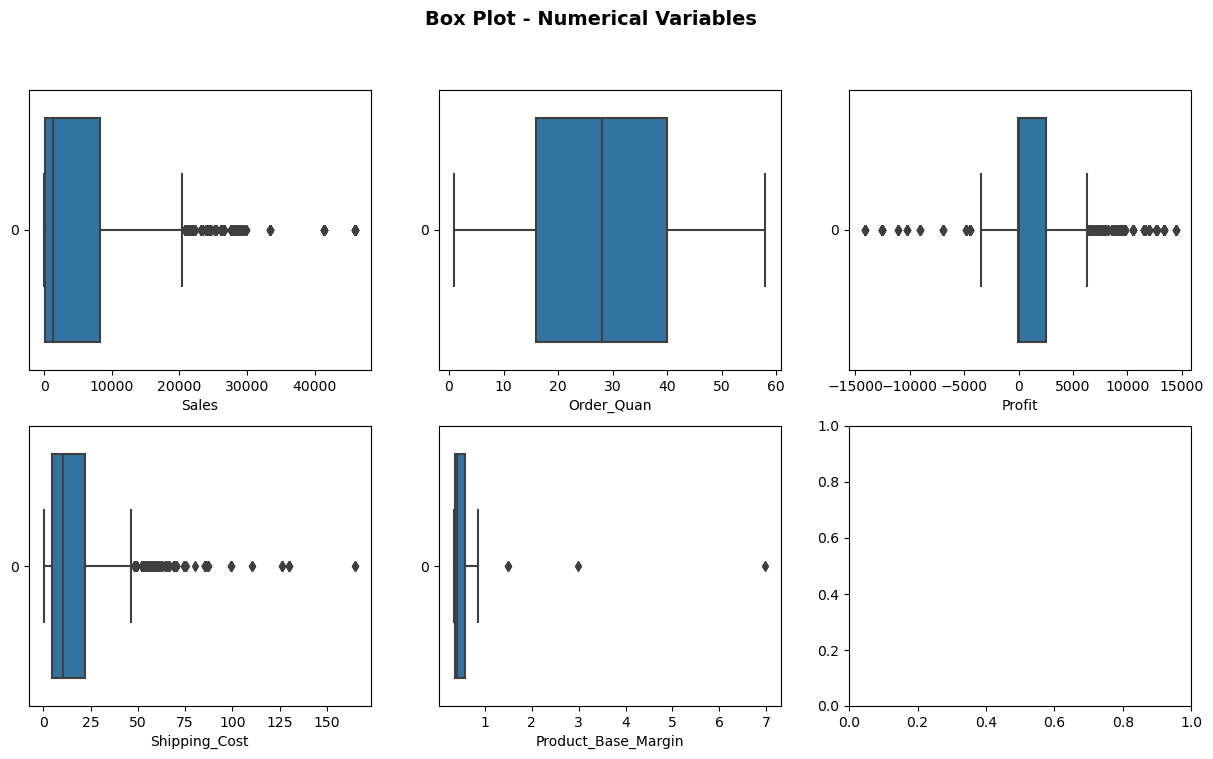

In [17]:
#Check for outliers
df_num = df.drop(['Cust_id','Customer_Segment'], axis=1)

# plot boxplot for each numerical variable
# set the number of rows in subplot using the parameter 'nrows'
# set the number of columns in subplot using the parameter 'ncols'
# 'figsize' sets figure size
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

#use for loop to plot the boxplot for each variable
for i, subplot in zip(df_num.columns, ax.flatten()):

    #use boxplot() to plot the graph
    #pass the axes for the plot to the parameter, 'ax'
    sns.boxplot(df[i], ax=subplot, orient='h')
    #add title to x-axis 
    subplot.set_xlabel(i)
    
plt.suptitle('Box Plot - Numerical Variables', fontsize=14, fontweight='bold')

#display the plots
plt.show()

In [18]:
#Calculate the first quartile
Q1 = df_num.quantile(0.25)
print("The first quartile (Q1) is:\n", Q1)

#Calculate the third quartile
Q3 = df_num.quantile(0.75)
print("\nThe third quartile (Q3) is:\n", Q3)

#Calculate IQR
IQR = Q3-Q1
print("\nThe Interquartile Range (IQR) is:\n", IQR)

df_num = df_num[~((df_num < (Q1 - 1.5*IQR)) | (df_num >  (Q3 + 1.5*IQR))).any(axis=1)]
df_num.shape

The first quartile (Q1) is:
 Sales                  151.75
Order_Quan              16.00
Profit                 -35.98
Shipping_Cost            4.75
Product_Base_Margin      0.37
Name: 0.25, dtype: float64

The third quartile (Q3) is:
 Sales                  8315.641
Order_Quan               40.000
Profit                 2509.810
Shipping_Cost            21.990
Product_Base_Margin       0.580
Name: 0.75, dtype: float64

The Interquartile Range (IQR) is:
 Sales                  8163.891
Order_Quan               24.000
Profit                 2545.790
Shipping_Cost            17.240
Product_Base_Margin       0.210
dtype: float64


(5192, 5)

In [19]:
#check for missing values
df.isnull().sum()

Cust_id                0
Sales                  0
Order_Quan             0
Profit                 0
Shipping_Cost          0
Product_Base_Margin    0
Customer_Segment       0
dtype: int64

### Heirarchical Clustering
Agglomerative and Divisive, we consider Agglomerative for this problem

Scale the Data

In [20]:
#select the variables for model building and store it in features_df
#features_df = df[['Sales', 'Order_Quan', 'Profit', 'Shipping_Cost', 'Product_Base_Margin']]
features_df = df_num

#instantiate the 'StandardScaler'
scaler = StandardScaler()
#Fit the scaler to the feature data frame (this is where scaling happens)
scaled_features = scaler.fit_transform(features_df)

#Create a new DataFrame called scaled_df using the list of column names from features_df
scaled_df= pd.DataFrame(scaled_features, columns=features_df.columns)

print("\n\nFeatures before Scaling:\n")
print(features_df.head())

print("\n\nFeatures after Scaling:\n")
print(scaled_df.head())



Features before Scaling:

                     Sales  Order_Quan   Profit  Shipping_Cost  \
Products                                                         
COPIERS AND FAX  10909.641          40  2616.46          22.00   
COPIERS AND FAX  10607.641          27  2977.36          23.69   
PAPER              754.641          13    29.80           8.90   
PAPER              572.641          22    92.78          10.99   
OFFICE MACHINES  10128.641          50  5133.68          20.50   

                 Product_Base_Margin  
Products                              
COPIERS AND FAX                 0.57  
COPIERS AND FAX                 0.56  
PAPER                           0.37  
PAPER                           0.39  
OFFICE MACHINES                 0.36  


Features after Scaling:

      Sales  Order_Quan    Profit  Shipping_Cost  Product_Base_Margin
0  1.688612    0.870458  1.134118       1.060572             0.626189
1  1.620900   -0.038853  1.370695       1.232354             0.552718

In [21]:
# instantiate linkage object with scaled data and we consider 'ward' linkage method
link_mat =  linkage(scaled_features, method='ward')
print(link_mat[:,:10])


[[ 1113.          1253.             0.             2.        ]
 [ 1903.          5192.             0.             3.        ]
 [ 1133.          2146.             0.             2.        ]
 ...
 [10378.         10379.            61.43218937  3459.        ]
 [10373.         10377.            63.44276995  1733.        ]
 [10380.         10381.           155.83695925  5192.        ]]


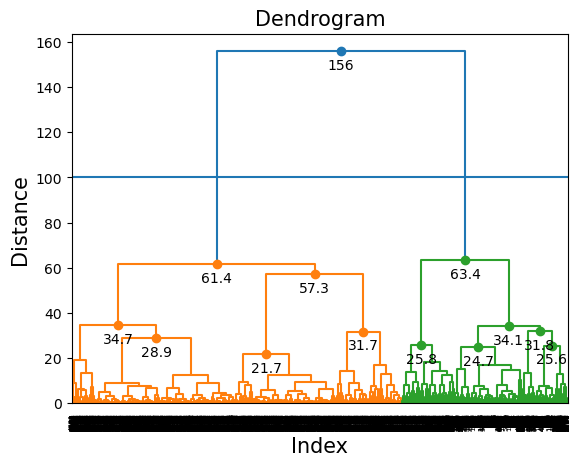

In [22]:
# plot the dendrogram
# pass the linkage matrix
dendro = dendrogram(link_mat)

# annotate the distance on the y-axis for distance > 20
# 'dendro' returns the dictionary containing x,y coordinates and the color list for each merge
# the 'icoord' returns the x-coordinates for the rectangle that represents the merging
# the 'dcoord' returns the y-coordinates (distance) for the each corner of the rectangle that represents the merging
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    
    # consider 'x' as the x-coordinate of the average distance on the merging line
    x = sum(i[1:3])/2
    
    # consider 'y' as the distance at which the merging occurs 
    y = d[1]
    
    # pass the if-condition for annotation
    if y > 20:
        
        # plot the bullet and annotate the merging distance 'y'
        plt.plot(x, y, 'o', c=c)
        
        # pass the conditions to annotate the distance
        plt.annotate("%.3g" % y, (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')

# plot the line to cut the dendrogram
plt.axhline(y = 100)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Dendrogram', fontsize = 15)
plt.xlabel('Index', fontsize = 15)
plt.ylabel('Distance', fontsize = 15)

# display the plot
plt.show()

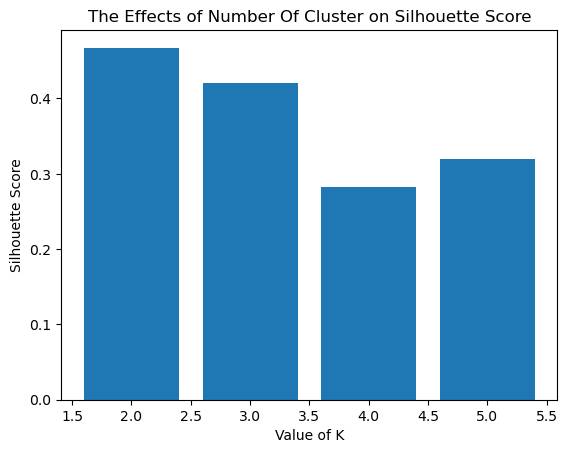

In [23]:
#consider different values of K
K = [2,3,4,5]

#consider an empty list to store the Silhouette Score
Sil_Score=[]

for i in K:
    
    #instantiate clustering for each values of K
    model = AgglomerativeClustering(n_clusters= i)

    #Calculate the Silhouette Score
    Sil_Score.append(silhouette_score(scaled_features, model.fit_predict(scaled_features)))

# plot the Silhouette Score for different K
plt.bar(K,  Sil_Score)
plt.xlabel('Value of K')
plt.ylabel('Silhouette Score')
plt.title('The Effects of Number Of Cluster on Silhouette Score')
plt.show()

In [24]:
# instantiate clustering method with 2 clusters and 'ward' linkage method
clusters  = AgglomerativeClustering(n_clusters=2, linkage='ward')
# fit the model to data scaled_features
clusters.fit(scaled_df)

AgglomerativeClustering()

In [25]:
df_num['Clusters'] = clusters.labels_
df_num.head()

,Sales,Order_Quan,Profit,Shipping_Cost,Product_Base_Margin,Clusters
Products,,,,,,
COPIERS AND FAX,10909.641,40,2616.46,22.00,0.57,0
COPIERS AND FAX,10607.641,27,2977.36,23.69,0.56,0
PAPER,754.641,13,29.80,8.90,0.37,1
PAPER,572.641,22,92.78,10.99,0.39,1
OFFICE MACHINES,10128.641,50,5133.68,20.50,0.36,0


In [26]:
df_num.Clusters.value_counts()

Clusters
1    3459
0    1733
Name: count, dtype: int64

In [27]:
df_num[df_num['Clusters'] == 0]['Sales'].mean()

8854.202956722447

In [28]:
df_num[df_num['Clusters'] == 1]['Sales'].mean()

634.8220216825671